# Polish Bankruptcy Data

In [26]:
#load the necessary modules
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

# Step 1 - Load The Data

In [31]:
#load your own path here where the datasets reside
path = '/home/brett/Documents/Datasets/ten-datasets/'

#load the dataset into a dataframe
polishdata = loadmat(path + 'Polish.mat')

#only looking at a single year at this stage. Not sure whether they is need to join up multiple years or not.
df = pd.DataFrame(polishdata['year5'])

Note, the following creates an 80/20 train/test split but this could be done more easily using sklearn functions which I'll look at.

In [32]:
#add a random number column so that we can split the data
df['random_sample'] = np.random.rand(1,len(df)).T 

In [33]:
#column 64 is the classification column indicating whether firm went bunkrupt or not. If the random number is less
#0.8 then its in the training set
y_train = df[64][df['random_sample'] <=.8]
#if the random number is greater than 0.8, then it is in the test set
y_test = df[64][df['random_sample'] >.8]

x_train = df.iloc[:,0:64][df['random_sample'] <=.8]
x_test = df.iloc[:,0:64][df['random_sample'] >.8]

## Support Functions

In [34]:
def model_fit_report(model,x_values,y_values_actual,y_values_predicted,y_values_probability):
    print("Model Fit Results")
    print("")
    print ("Accuracy: %0.3f" % accuracy_score(y_values_actual,y_values_predicted))
    print("")
    print("Confusion Matrix")
    CM = plot_confusion_matrix(model,x_values,y_values_actual,values_format = 'n')
    print (CM)
    print("")
    print (confusion_matrix(y_values_actual,y_values_predicted))
    print("")
    print("Classification Report")
    print("")
    print (classification_report(y_values_actual,y_values_predicted))
    print("")
    plot_roc_curve(model, x_values, y_values_actual)
    

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [58]:
#'C' is regularisation parameter. low values equal high degree of regularisation 
#and variable removal to avoid overfitting
lr = LogisticRegression(C=0.1,random_state=1,max_iter = 1000, tol=.1, solver ='sag')

In [59]:
#scale the input variables to improve efficiency of learning algorithm
mms = MinMaxScaler()
x_train_scaled = mms.fit_transform(x_train)
x_test_scaled = mms.fit_transform(x_test)

In [60]:
#lr.fit(x_train_scaled,y_train)
lr.fit(x_train_scaled,y_train)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='sag', tol=0.1, verbose=0,
                   warm_start=False)

Model Fit Results

Accuracy: 0.933

Confusion Matrix

[[4438    2]
 [ 318    3]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      4440
         1.0       0.60      0.01      0.02       321

    accuracy                           0.93      4761
   macro avg       0.77      0.50      0.49      4761
weighted avg       0.91      0.93      0.90      4761


Model Fit Results

Accuracy: 0.914

Confusion Matrix

[[1038   22]
 [  77   12]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      1060
         1.0       0.35      0.13      0.20        89

    accuracy                           0.91      1149
   macro avg       0.64      0.56      0.57      1149
weighted avg       0.89      0.91      0.90      1149




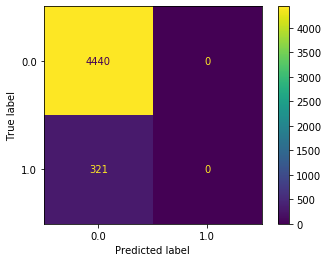

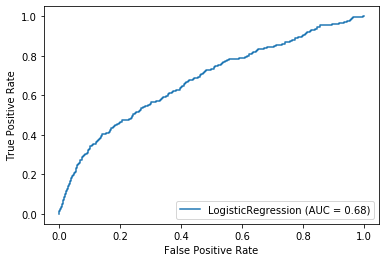

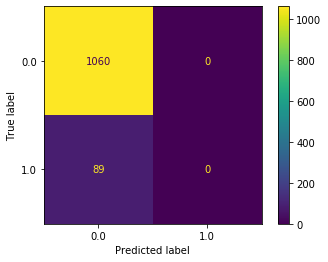

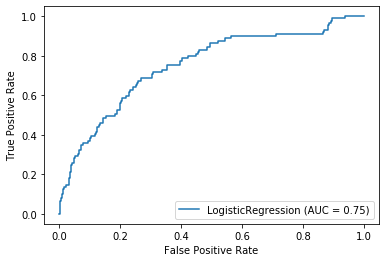

In [61]:
#y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)
y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)
probs = lr.predict_proba(x_train_scaled)
df_probs = pd.DataFrame(probs)

#training results
#override the default 0.5 threshold for predicitng class in binary setting (as sample is so biased)
y_train_predict = df_probs[[1]].applymap(lambda x: 1 if x>0.1 else 0).to_numpy().reshape(-1)
#model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled)[:,1])
model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled)[:,1])

#testing results
y_test_predict = lr.predict_proba(x_test_scaled).argmax(axis = 1)
#override the default 0.5 threshold for predicitng class in binary setting (as sample is so biased)
probs = lr.predict_proba(x_test_scaled)
df_probs = pd.DataFrame(probs)
y_test_predict = df_probs[[1]].applymap(lambda x: 1 if x>0.1 else 0).to_numpy().reshape(-1)
model_fit_report(lr,x_test_scaled,y_test,y_test_predict,lr.predict_proba(x_test_scaled)[:,1])



In [62]:
num_coeff = 0
for i in range(len(lr.coef_[0])):
    #print ('coefficient %i = %.2f ' % (i, lr.coef_[0][i]))
    if abs(lr.coef_[0][i]) > .01:
        num_coeff += 1
        
print ('Number of non-zero coefficients: %i' %num_coeff)

Number of non-zero coefficients: 54


With Principal Components Instead

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.fit_transform(x_test_scaled)
np.set_printoptions(suppress = True)
print(pca.explained_variance_ratio_)

[0.25395491 0.15790918 0.09369734 0.085088   0.06080389 0.03961006
 0.02954936 0.02761952 0.02712319 0.02170706]


Model Fit Results

Accuracy: 0.932

Confusion Matrix

[[4434    6]
 [ 318    3]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      4440
         1.0       0.33      0.01      0.02       321

    accuracy                           0.93      4761
   macro avg       0.63      0.50      0.49      4761
weighted avg       0.89      0.93      0.90      4761


Model Fit Results

Accuracy: 0.922

Confusion Matrix

[[1047   13]
 [  77   12]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      1060
         1.0       0.48      0.13      0.21        89

    accuracy                           0.92      1149
   macro avg       0.71      0.56      0.58      1149
weighted avg       0.90      0.92      0.90      1149




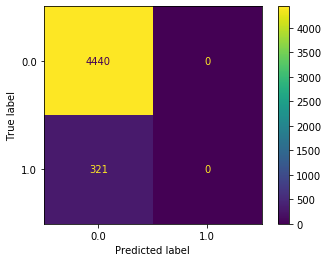

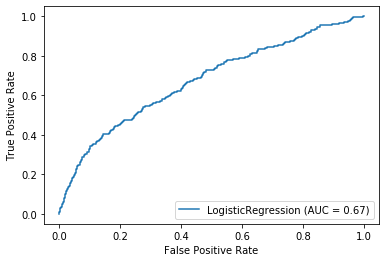

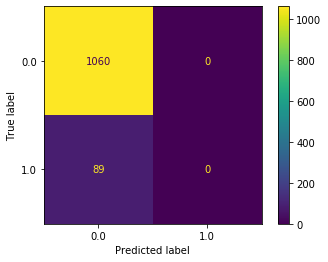

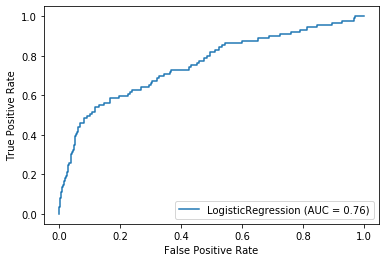

In [65]:
lr.fit(x_train_pca,y_train)


#y_train_predict = lr.predict_proba(x_train_scaled).argmax(axis = 1)
y_train_predict = lr.predict_proba(x_train_pca).argmax(axis = 1)
probs = lr.predict_proba(x_train_pca)
df_probs = pd.DataFrame(probs)

#training results
#override the default 0.5 threshold for predicitng class in binary setting (as sample is so biased)
y_train_predict = df_probs[[1]].applymap(lambda x: 1 if x>0.1 else 0).to_numpy().reshape(-1)
#model_fit_report(lr,x_train_scaled,y_train,y_train_predict,lr.predict_proba(x_train_scaled)[:,1])
model_fit_report(lr,x_train_pca,y_train,y_train_predict,lr.predict_proba(x_train_pca)[:,1])

#testing results
y_test_predict = lr.predict_proba(x_test_pca).argmax(axis = 1)
#override the default 0.5 threshold for predicitng class in binary setting (as sample is so biased)
probs = lr.predict_proba(x_test_pca)
df_probs = pd.DataFrame(probs)
y_test_predict = df_probs[[1]].applymap(lambda x: 1 if x>0.1 else 0).to_numpy().reshape(-1)
model_fit_report(lr,x_test_pca,y_test,y_test_predict,lr.predict_proba(x_test_pca)[:,1])

Results using PCA look better than without (slightly)

# SVM

SVM Train Accuracy: 0.934
Model Fit Results

Accuracy: 0.934

Confusion Matrix

[[4440    0]
 [ 316    5]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      4440
         1.0       1.00      0.02      0.03       321

    accuracy                           0.93      4761
   macro avg       0.97      0.51      0.50      4761
weighted avg       0.94      0.93      0.90      4761


Model Fit Results

Accuracy: 0.078

Confusion Matrix

[[   2 1058]
 [   1   88]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.67      0.00      0.00      1060
         1.0       0.08      0.99      0.14        89

    accuracy                           0.08      1149
   macro avg       0.37      0.50      0.07      1149
weighted avg       0.62      0.08      0.01      1149




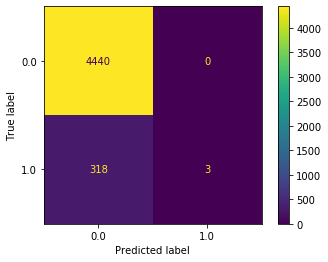

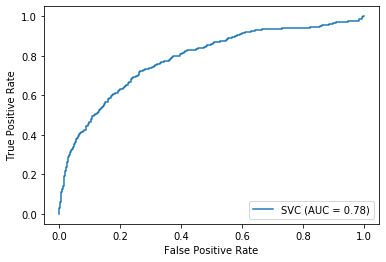

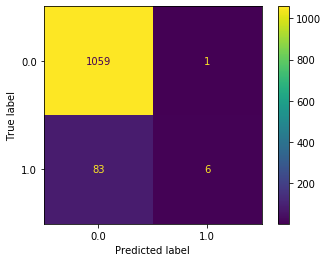

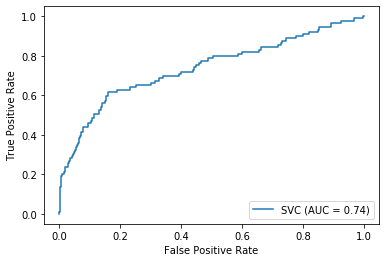

In [70]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear',C=1.0, random_state=1, probability = True )
svm.fit(x_train_scaled,y_train)
y_train_predict = svm.predict_proba(x_train_scaled).argmax(axis = 1)
print ("SVM Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
model_fit_report(svm,x_train_scaled,y_train,y_train_predict,svm.predict_proba(x_train_scaled)[:,1])
y_test_predict = svm.predict_proba(x_test_scaled).argmax(axis = 1)
model_fit_report(svm,x_test_scaled,y_test,y_test_predict,svm.predict_proba(x_test_scaled)[:,1])

# Decision Tree

Decision Tree Train Accuracy: 0.954
Model Fit Results

Accuracy: 0.954

Confusion Matrix

[[4435    5]
 [ 213  108]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      4440
         1.0       0.96      0.34      0.50       321

    accuracy                           0.95      4761
   macro avg       0.95      0.67      0.74      4761
weighted avg       0.95      0.95      0.94      4761


Decision Tree Test Accuracy: 0.940
Model Fit Results

Accuracy: 0.940

Confusion Matrix

[[1056    4]
 [  65   24]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1060
         1.0       0.86      0.27      0.41        89

    accuracy                           0.94      1149
   macro avg       0.90      0.63      0.69      1149
weighted avg       0.94      0.94      0.93      1149




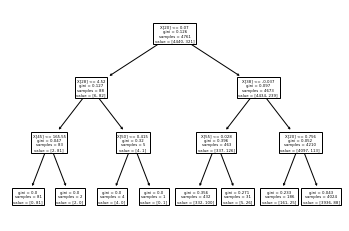

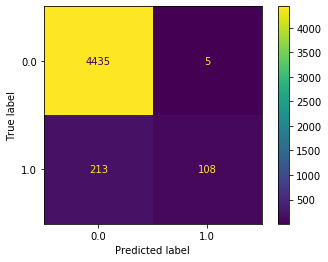

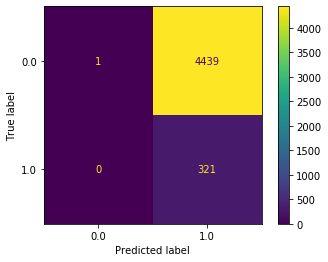

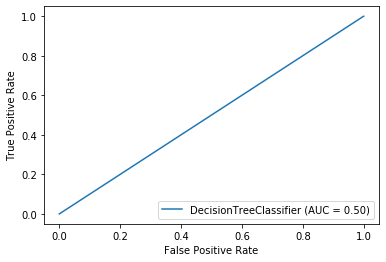

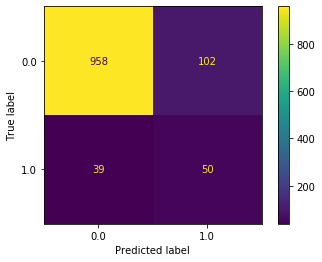

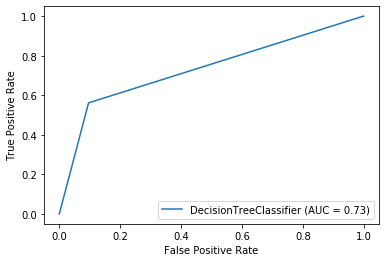

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

xtree = DecisionTreeClassifier(criterion='gini',max_depth=3, random_state=1)
results = xtree.fit(x_train,y_train)
tree.plot_tree(results.fit(x_train, y_train)) 
y_train_predict = xtree.predict(x_train)
print ("Decision Tree Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))
plot_confusion_matrix(xtree,x_train,y_train,values_format = 'n')
model_fit_report(xtree,x_train_scaled,y_train,y_train_predict,xtree.predict_proba(x_train_scaled)[:,1])
y_test_predict = xtree.predict(x_test)
print ("Decision Tree Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))
model_fit_report(xtree,x_test_scaled,y_test,y_test_predict,xtree.predict_proba(x_test_scaled)[:,1])

# Random Forrest

Model Fit Results

Accuracy: 0.939

Confusion Matrix

[[4405   35]
 [ 257   64]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      4440
         1.0       0.65      0.20      0.30       321

    accuracy                           0.94      4761
   macro avg       0.80      0.60      0.64      4761
weighted avg       0.92      0.94      0.92      4761


Model Fit Results

Accuracy: 0.932

Confusion Matrix

[[1050   10]
 [  68   21]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      1060
         1.0       0.68      0.24      0.35        89

    accuracy                           0.93      1149
   macro avg       0.81      0.61      0.66      1149
weighted avg       0.92      0.93      0.92      1149




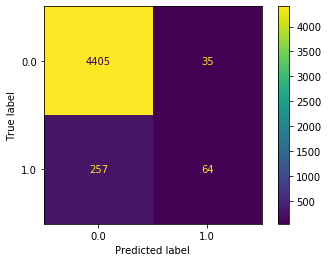

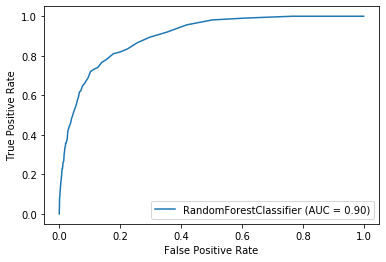

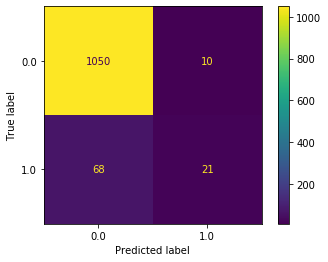

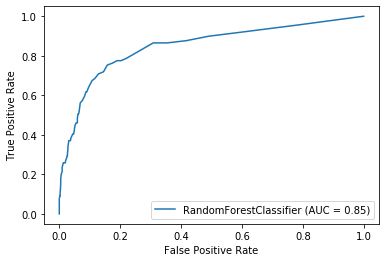

In [73]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators = 50, random_state =1,max_samples =100)
forest.fit(x_train,y_train)
y_train_predict = forest.predict(x_train)
#training results
model_fit_report(forest,x_train,y_train,y_train_predict,forest.predict_proba(x_train_scaled)[:,1])
y_test_predict = forest.predict(x_test)
#testing results
model_fit_report(forest,x_test,y_test,y_test_predict,forest.predict_proba(x_test)[:,1])

# NN (MLP) via Sklearn

In [74]:
from sklearn.neural_network import MLPClassifier

Model Fit Results

Accuracy: 0.936

Confusion Matrix

[[4427   13]
 [ 291   30]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      4440
         1.0       0.70      0.09      0.16       321

    accuracy                           0.94      4761
   macro avg       0.82      0.55      0.57      4761
weighted avg       0.92      0.94      0.91      4761


Model Fit Results

Accuracy: 0.900

Confusion Matrix

[[1024   36]
 [  79   10]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1060
         1.0       0.22      0.11      0.15        89

    accuracy                           0.90      1149
   macro avg       0.57      0.54      0.55      1149
weighted avg       0.87      0.90      0.88      1149




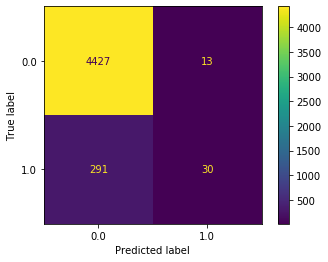

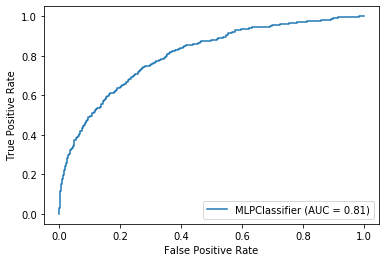

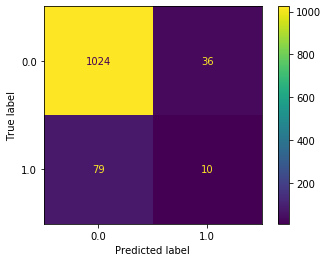

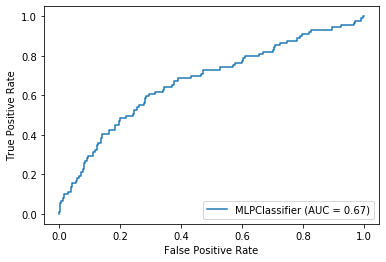

In [86]:
NN = MLPClassifier(solver='adam', 
                   alpha=1e-3,
                   hidden_layer_sizes=(50,50), 
                   random_state=1,
                   max_iter=1000,
                   activation = 'relu')

NN.fit(x_train_scaled,y_train)
y_train_predict = NN.predict(x_train_scaled)
#train results
model_fit_report(NN,x_train_scaled,y_train,y_train_predict,NN.predict_proba(x_train_scaled)[:,1])
y_test_predict = NN.predict(x_test_scaled)
NN.predict_proba(x_test_scaled)
#test results
model_fit_report(NN,x_test_scaled,y_test,y_test_predict,NN.predict_proba(x_test_scaled)[:,1])

# MLP with Keras

In [87]:
import tensorflow.keras as keras

In [88]:
#convert labels to binary format (0,1)
from keras.utils import to_categorical
y_train_binary = to_categorical(y_train)

Using TensorFlow backend.


In [127]:
#create the same 2 layer, 50 unit model as per previous sklearn example
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = x_train_scaled.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(
    keras.layers.Dense(
        units = 100, 
        input_dim = 100,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation ='relu'))

model.add(
    keras.layers.Dense(
    units=y_train_binary.shape[1],
    input_dim=100,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation ='softmax'))


In [128]:
sgd_optimiser = keras.optimizers.SGD(
    lr=0.0001)

model.compile(optimizer=sgd_optimiser,loss ='categorical_crossentropy')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               6500      
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 16,802
Trainable params: 16,802
Non-trainable params: 0
_________________________________________________________________


In [129]:
history = model.fit(x_train_scaled,y_train_binary,batch_size=50,epochs =10, verbose =1, validation_split = 0.3)

Train on 3332 samples, validate on 1429 samples
Epoch 1/10
3332/3332 [==============================] - 1s 228us/sample - loss: 0.8285 - val_loss: 0.7381
Epoch 2/10
3332/3332 [==============================] - 0s 89us/sample - loss: 0.7258 - val_loss: 0.6855
Epoch 3/10
3332/3332 [==============================] - 0s 104us/sample - loss: 0.6406 - val_loss: 0.6447
Epoch 4/10
3332/3332 [==============================] - 0s 94us/sample - loss: 0.5692 - val_loss: 0.6130
Epoch 5/10
3332/3332 [==============================] - 0s 101us/sample - loss: 0.5092 - val_loss: 0.5891
Epoch 6/10
3332/3332 [==============================] - 0s 148us/sample - loss: 0.4593 - val_loss: 0.5712
Epoch 7/10
3332/3332 [==============================] - 0s 108us/sample - loss: 0.4169 - val_loss: 0.5577
Epoch 8/10
3332/3332 [==============================] - 0s 107us/sample - loss: 0.3803 - val_loss: 0.5477
Epoch 9/10
3332/3332 [==============================] - 0s 117us/sample - loss: 0.3484 - val_loss: 0.5404


In [130]:
y_train_predict = model.predict_classes(x_train_scaled,verbose=0)

In [131]:
print ("Keras MLP Train Accuracy: %.3f" % accuracy_score(y_train,y_train_predict))

Keras MLP Train Accuracy: 0.933


In [132]:
y_test_predict = model.predict_classes(x_test_scaled,verbose=0)

In [133]:
print ("Keras MLP Test Accuracy: %.3f" % accuracy_score(y_test,y_test_predict))

Keras MLP Test Accuracy: 0.923
